Processing Random Forest Chunk 1 with 50000 samples...
Processing Random Forest Chunk 2 with 50000 samples...
Processing Random Forest Chunk 3 with 50000 samples...
Processing Random Forest Chunk 4 with 50000 samples...
Processing Random Forest Chunk 5 with 50000 samples...
Processing Random Forest Chunk 6 with 50000 samples...
Processing Random Forest Chunk 7 with 50000 samples...
Processing Random Forest Chunk 8 with 50000 samples...
Processing Random Forest Chunk 9 with 50000 samples...
Processing Random Forest Chunk 10 with 50000 samples...
Processing Random Forest Chunk 11 with 50000 samples...
Processing Random Forest Chunk 12 with 50000 samples...
Processing Random Forest Chunk 13 with 50000 samples...
Processing Random Forest Chunk 14 with 50000 samples...
Processing Random Forest Chunk 15 with 50000 samples...
Processing Random Forest Chunk 16 with 50000 samples...
Processing Random Forest Chunk 17 with 50000 samples...
Processing Random Forest Chunk 18 with 50000 samples...
P

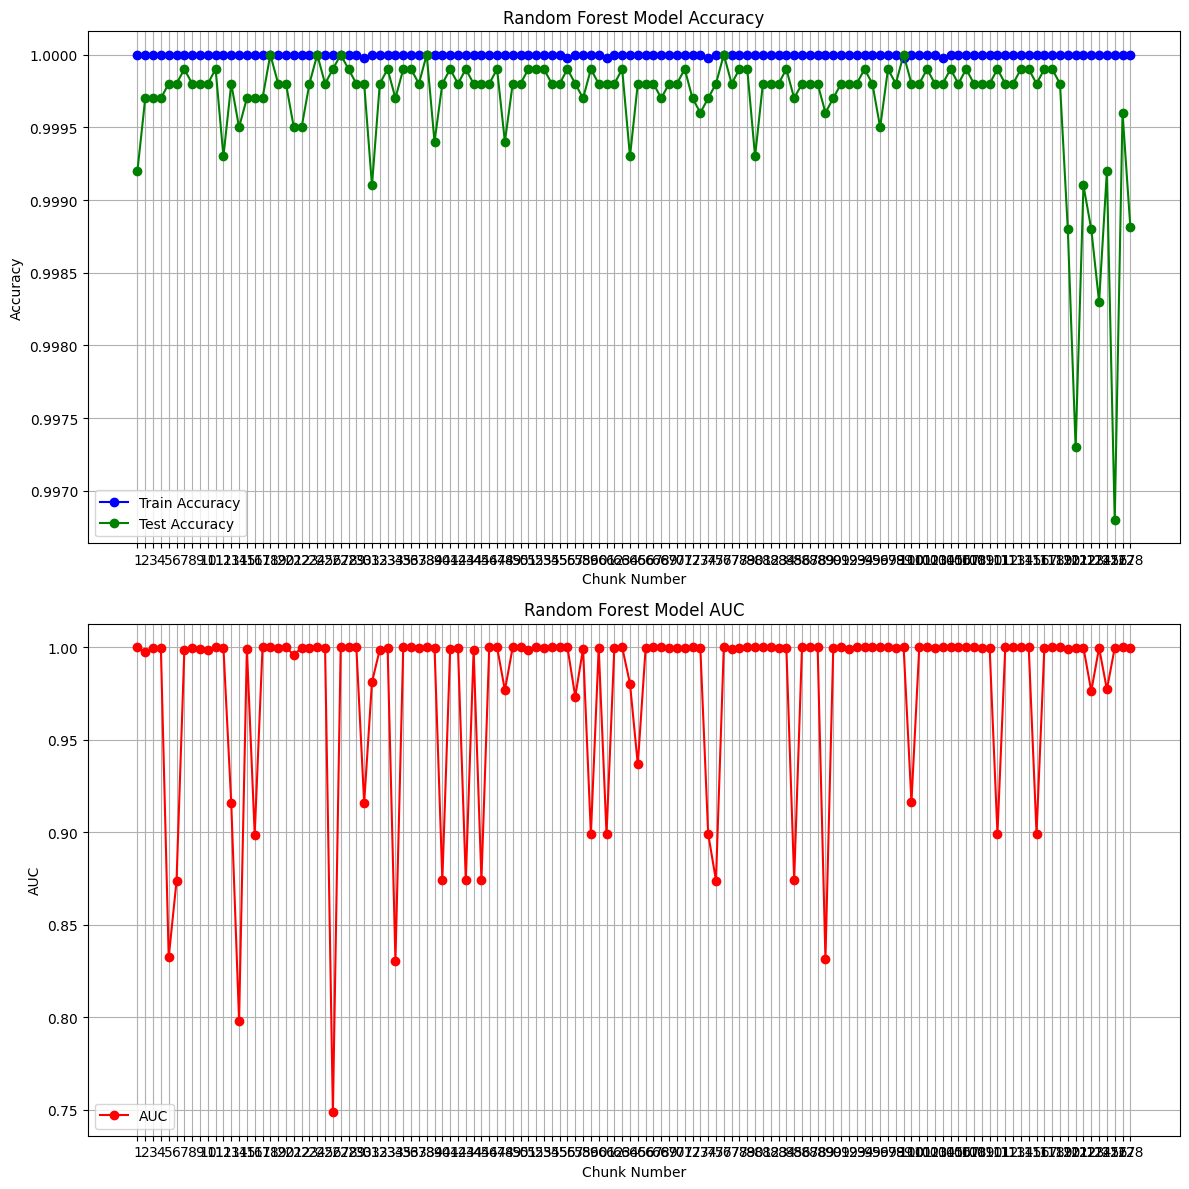

In [5]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Function to preprocess data
def preprocess_data(chunk):
    # Drop unnecessary columns
    chunk.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
    
    # Encode categorical variable 'type' using one-hot encoding
    enc = OneHotEncoder()
    type_encoded = enc.fit_transform(chunk[['type']])
    
    # Extracting feature names for the one-hot encoded column
    feature_names = enc.get_feature_names_out(['type'])
    
    # Convert encoded result to DataFrame and concatenate with original chunk
    type_encoded_df = pd.DataFrame(type_encoded.toarray(), columns=feature_names)
    chunk_processed = pd.concat([chunk.reset_index(drop=True), type_encoded_df], axis=1)
    
    # Drop the original 'type' column
    chunk_processed.drop(['type'], axis=1, inplace=True)
    
    return chunk_processed

# Function to process Random Forest chunks and calculate accuracies and AUC
def process_random_forest(file_path, chunk_size):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Example: 100 estimators
    scaler = StandardScaler()
    
    train_accuracies = []
    test_accuracies = []
    auc_scores = []
    
    # Total counts for progress tracking
    total_chunks = 0
    total_samples = 0
    
    # Initialize StratifiedShuffleSplit
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        chunk_processed = preprocess_data(chunk)
        
        X = chunk_processed.drop('isFraud', axis=1)
        y = chunk_processed['isFraud']
        
        total_chunks += 1
        total_samples += len(chunk)
        
        print(f"Processing Random Forest Chunk {total_chunks} with {len(chunk)} samples...")
        
        # Check if more than one class is present in the chunk
        if len(y.unique()) < 2:
            print(f"Skipping Random Forest training for Chunk {total_chunks} due to only one class present.")
            continue
        
        # Scale the features
        X_scaled = scaler.fit_transform(X)
        
        # Use StratifiedShuffleSplit to split the data
        for train_idx, test_idx in splitter.split(X_scaled, y):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train the Random Forest model
        rf_model.fit(X_train, y_train)
        
        # Evaluate the model on train set
        train_accuracy = rf_model.score(X_train, y_train)
        train_accuracies.append(train_accuracy)
        
        # Evaluate the model on test set
        test_accuracy = rf_model.score(X_test, y_test)
        test_accuracies.append(test_accuracy)
        
        # Calculate AUC on test set if both classes are present
        if len(y_test.unique()) > 1:
            y_prob = rf_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)
            auc = roc_auc_score(y_test, y_prob)
            auc_scores.append(auc)
        else:
            print(f"Skipping AUC calculation for Chunk {total_chunks} due to only one class present in y_test.")
    
    print(f"Random Forest: Processed {total_chunks} chunks with {total_samples} samples in total.")
    return train_accuracies, test_accuracies, auc_scores

# Function to plot Random Forest accuracies and AUC
def plot_rf_results(train_accuracies, test_accuracies, auc_scores):
    plt.figure(figsize=(12, 12))
    
    # Plot train and test accuracies
    plt.subplot(2, 1, 1)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', linestyle='-', color='b', label='Train Accuracy')
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-', color='g', label='Test Accuracy')
    
    # Add labels and title
    plt.xlabel('Chunk Number')
    plt.ylabel('Accuracy')
    plt.title('Random Forest Model Accuracy')
    plt.xticks(range(1, len(train_accuracies) + 1))
    
    # Add legend and grid
    plt.legend()
    plt.grid(True)
    
    # Plot AUC scores
    plt.subplot(2, 1, 2)
    if auc_scores:
        plt.plot(range(1, len(auc_scores) + 1), auc_scores, marker='o', linestyle='-', color='r', label='AUC')
    
    # Add labels and title
    plt.xlabel('Chunk Number')
    plt.ylabel('AUC')
    plt.title('Random Forest Model AUC')
    plt.xticks(range(1, len(auc_scores) + 1))
    
    # Add legend and grid
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage
file_path = 'Synthetic_Financial_datasets_log.csv'  # Replace with your actual file path
chunk_size = 50000  # Adjust chunk size as needed

# Process Random Forest chunks and get train and test accuracies
rf_train_accuracies, rf_test_accuracies, rf_auc_scores = process_random_forest(file_path, chunk_size)

# Plot Random Forest results
plot_rf_results(rf_train_accuracies, rf_test_accuracies, rf_auc_scores)
